In [19]:
#Importing the Libraries
from os import minor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.utils.vis_utils import plot_model

In [20]:

#Get The Dataset
df = pd.read_csv('../CSV/MSFT_kaggle.csv', na_values=['null'], index_col='Date', parse_dates=True,infer_datetime_format=True)
# print(df.head())

#Print the shape of Dataframe and Check for Null values
# print('Df Shape: ', df.shape)
# print('Null values present: ', df.isnull().values.any())

#plot the true adj close value
# df['Adj Close'].plot()
# plt.show()

#Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])

#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
# print(feature_transform.head())


#splitting to Training set and Test Set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
  # X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index) + len(test_index))]
  X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): ]
  y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index) + len(test_index))].values.ravel()

#process the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])



#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="selu", return_sequences=False))
# lstm.add(LSTM(32, activation="tanh", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
# plot_model(lstm, show_shapes=True, show_layer_names=True)

In [21]:
#early stopping
earlyStop = EarlyStopping(
  monitor='loss',
  min_delta=0.01,
  patience=25,
  mode='min',
  verbose=1,
  restore_best_weights=True
)

In [22]:

#Model Training
# history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)
history=lstm.fit(X_train, y_train, epochs=300, batch_size=8, verbose=1, shuffle=False, callbacks=[earlyStop])

#LSTM Prediction
y_pred = lstm.predict(X_test)



Epoch 1/300
958/958 [==============================] - 2s 1ms/step - loss: 4.4942
Epoch 2/300
958/958 [==============================] - 1s 2ms/step - loss: 33.5864
Epoch 3/300
958/958 [==============================] - 1s 1ms/step - loss: 5.4616
Epoch 4/300
958/958 [==============================] - 1s 1ms/step - loss: 1.5485
Epoch 5/300
958/958 [==============================] - 1s 1ms/step - loss: 1.1940
Epoch 6/300
958/958 [==============================] - 1s 1ms/step - loss: 1.0882
Epoch 7/300
958/958 [==============================] - 1s 1ms/step - loss: 1.0020
Epoch 8/300
958/958 [==============================] - 1s 1ms/step - loss: 0.9390
Epoch 9/300
958/958 [==============================] - 1s 1ms/step - loss: 0.8966
Epoch 10/300
958/958 [==============================] - 1s 1ms/step - loss: 0.8687
Epoch 11/300
958/958 [==============================] - 1s 1ms/step - loss: 0.8503
Epoch 12/300
958/958 [==============================] - 1s 1ms/step - loss: 0.8377
Epoch 13/300

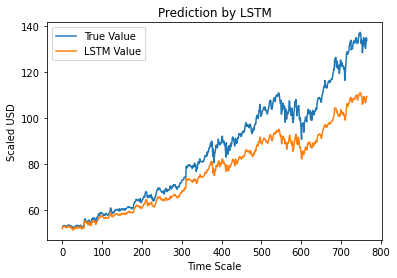

In [23]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()

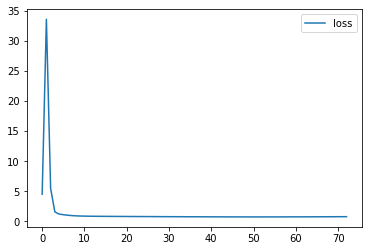

In [24]:
pd.DataFrame(history.history).plot()
plt.show()